In [ ]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_excel('Dataset_Fix.xlsx', skiprows=8, usecols=lambda col: col != "Tanggal")
df

,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg
0,19.2,30.2,24.2,77,0.0,6.4,4,80,2
1,20.0,31.3,25.2,69,0.0,8.4,5,70,2
2,20.3,29.0,24.3,72,0.0,9.6,5,200,3
3,19.8,29.0,23.7,78,0.0,9.0,3,170,2
4,19.4,29.3,23.8,78,16.4,5.7,5,90,2
...,...,...,...,...,...,...,...,...,...
361,17.0,29.6,22.6,71,0.0,6.5,5,70,2
362,17.9,31.2,23.4,66,NaN,8.0,5,80,2
363,16.0,29.8,22.9,67,0.0,9.6,4,70,2
364,18.2,29.9,23.1,74,0.0,10.0,4,200,2


In [ ]:
def preprocessing(df, test_size):
  #Proses mengatasi missing values
  for column in df.columns:
    for i in range(len(df)):
        if pd.notna(df[column].iloc[i]):
            continue  # Skip non-NaN values

        previous = i - 1
        next_value = i + 1

        while previous >= 0 and pd.isna(df[column].iloc[previous]):
            previous -= 1

        while next_value < len(df) and pd.isna(df[column].iloc[next_value]):
            next_value += 1

        df[column].iloc[i] = (df[column].iloc[previous] + df[column].iloc[next_value]) / 2

  #Normalisasi Min-Max
  scaler = MinMaxScaler()
  df_normalization = scaler.fit_transform(df)
  df_normalization = pd.DataFrame(df_normalization, columns=df.columns)

  df_features = df_normalization.loc[:, df_normalization.columns != 'RR']
  df_target = df_normalization.loc[:, df_normalization.columns == "RR"]

  df_features2 = df.loc[:, df.columns != 'RR']
  df_target2 = df.loc[:, df.columns == "RR"]

  X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=test_size, random_state=42)
  X_train2, X_test2, y_train2, y_test2 = train_test_split(df_features2, df_target2, test_size=test_size, random_state=42)
  return (X_train, X_test, y_train, y_test), (X_train2, X_test2, y_train2, y_test2)

In [ ]:
def elm_fit(X, target, h):
    start_time = time.time()
    W = np.random.uniform(-1, 1, (h, X.shape[1]))
    Hinit = X @ W.T
    H = 1 / (1 + np.exp(-Hinit))

    Ht = H.T
    Hp = np.linalg.inv(Ht @ H) @ Ht
    beta = Hp @ target
    y = H @ beta

    execution = time.time() - start_time
    return W, beta, execution

In [ ]:
def elm_testing(X, W, target, b):
  Hinit = X @ W.T
  H = 1 / (1 + np.exp(-Hinit))
  y = H @ b
  mse = np.mean(np.square(y-target))
  return y,mse

In [ ]:
dataset_norm,dataset = preprocessing(df, 0.2)
W, b, time_computing = elm_fit(dataset_norm[0], dataset_norm[2], 5)
output,msd = elm_testing(dataset_norm[1], W, dataset_norm[3], b)

<ipython-input-22-7df164d2d262>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[i] = (df[column].iloc[previous] + df[column].iloc[next_value]) / 2
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
def denormalization(output_testing, target_testing):
  y_denormalization = (output_testing*(np.max(target_testing) - np.min(target_testing))) + np.min(target_testing)
  return y_denormalization

In [ ]:
#y_denormalization = (dataset_norm[3]*(np.max(dataset[3]) - np.min(dataset[3]))) + np.min(dataset[3])
y_denormalization = denormalization(dataset_norm[3],dataset[3])
y_denormalization

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


,RR
193,0.0
33,0.0
15,0.0
310,1.0
57,0.0
...,...
82,17.8
94,1.6
192,2.7
307,0.0


## Hyperparameter Jumlah Hidden Neuron

In [ ]:
def n_hidden_neuron(dataset_norm, dataset, n_hidden):
  W, b, time_computing = elm_fit(dataset_norm[0], dataset_norm[2], n_hidden)
  output,mse = elm_testing(dataset_norm[1], W, dataset_norm[3], b)
  y_denormalization = denormalization(dataset_norm[3],dataset[3])
  return y_denormalization, mse, time_computing

In [ ]:
hyperparameter = []
for i in range(1,11):
  output_denormalization, mse, time_computing = n_hidden_neuron(dataset_norm, dataset, i)
  hyperparameter.append([i, mse[0], time_computing])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumer

In [ ]:
hyperparameter_hidden_neuron = pd.DataFrame(hyperparameter,columns=['Jumlah Hidden Neuron','MSE','Time Computing'])

In [ ]:
hyperparameter_hidden_neuron.to_excel('hyperparameter.xlsx')
hyperparameter_hidden_neuron

,Jumlah Hidden Neuron,MSE,Time Computing
0,1,0.029540,0.002914
1,2,0.029092,0.002254
2,3,0.029393,0.002164
3,4,0.029153,0.004256
4,5,0.027820,0.002339
5,6,0.027526,0.002224
6,7,0.026834,0.002226
7,8,0.027528,0.002233
8,9,0.027561,0.002246
9,10,0.026422,0.006205


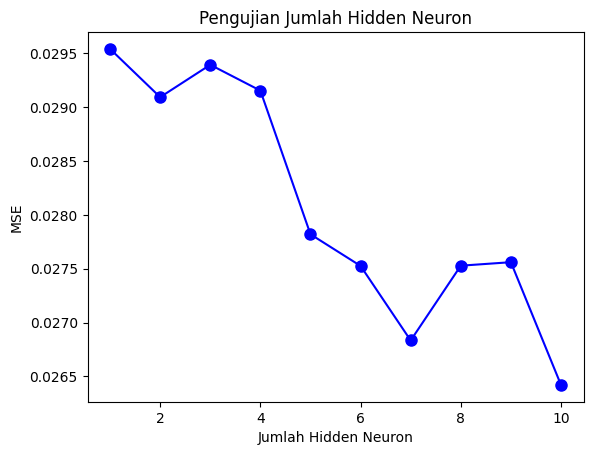

In [ ]:
plt.plot(hyperparameter_hidden_neuron['Jumlah Hidden Neuron'], hyperparameter_hidden_neuron['MSE'], color='blue', linestyle='-', marker='o', markersize=8)
plt.xlabel('Jumlah Hidden Neuron')
plt.ylabel('MSE')
plt.title('Pengujian Jumlah Hidden Neuron')
plt.savefig('hidden_neuron.png')
plt.show()

## Hyperparameter Jumlah Data Latih dan Data Uji

In [ ]:
def n_testing_size(df, test_size, n_hidden):
  dataset_norm,dataset = preprocessing(df, test_size)
  W, b, time_computing = elm_fit(dataset_norm[0], dataset_norm[2], n_hidden)
  output,mse = elm_testing(dataset_norm[1], W, dataset_norm[3], b)
  y_denormalization = denormalization(dataset_norm[3],dataset[3])
  return y_denormalization, mse, time_computing

In [ ]:
hyperparameter2 = []
n_testing = [0.5, 0.4, 0.3, 0.2, 0.1]
for j in n_testing:
  output_denormalization, mse, time_computing = n_testing_size(df, j, 10)
  hyperparameter2.append([j, mse[0], time_computing])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumer

In [ ]:
#hyperparameter_testing = pd.DataFrame(hyperparameter2,columns=['Jumlah Testing','MSE','Time Computing'])
#hyperparameter_testing.to_excel('hyperparameter2.xlsx')
#hyperparameter_testing

,Jumlah Testing,MSE,Time Computing
0,0.5,0.020397,0.002784
1,0.4,0.025744,0.002470
2,0.3,0.023329,0.002581
3,0.2,0.027499,0.002549
4,0.1,0.043363,0.002495


In [ ]:
hyperparameter_testing = pd.read_excel("hyperparameter2.xlsx")
hyperparameter_testing

,Jumlah Testing,MSE,Time Computing
0,0.5,0.020715,0.002357
1,0.4,0.024336,0.002337
2,0.3,0.022790,0.002304
3,0.2,0.026959,0.002447
4,0.1,0.043974,0.002538


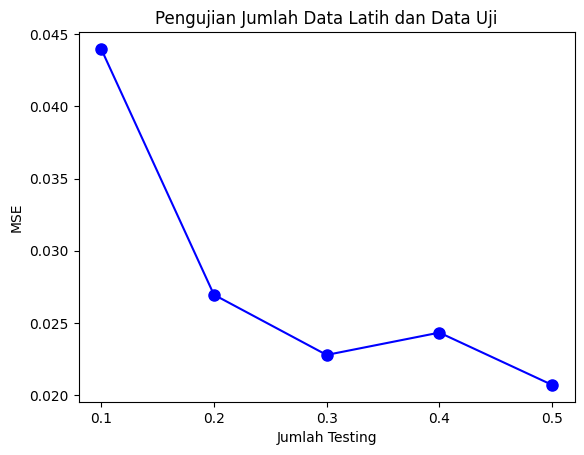

In [ ]:
plt.plot(hyperparameter_testing['Jumlah Testing'], hyperparameter_testing['MSE'], color='blue', linestyle='-', marker='o', markersize=8)
plt.xlabel('Jumlah Testing')
plt.ylabel('MSE')
plt.xticks(hyperparameter_testing['Jumlah Testing'])
plt.title('Pengujian Jumlah Data Latih dan Data Uji')
plt.savefig('hyper_testing.png')
plt.show()